## Load the shuffled_100

1. Load the projects
2. load the shuffled_100 for all the sessions 
3. merge both light and dark trials together 
4. calculate the model performance 
5. plot the summary for all the shuffling

In [8]:
%load_ext autoreload
%autoreload 2

import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import spikeA
from spikeA.Spike_train import Spike_train
from spikeA.Animal_pose import Animal_pose
from spikeA.Spatial_properties import Spatial_properties
from spikeA.Neuron import Simulated_place_cell, Simulated_grid_cell
from scipy.stats import poisson
from scipy.interpolate import interp1d
from tqdm import tqdm
from scipy import stats
from scipy import ndimage
from astropy.stats import circcorrcoef
from astropy import units as u
from functions import *
from lstmModel import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
%run ../../setup_project.py
%run ../../neuronAutopi.py

%run ../../generic_plot_functions.py

projectName, dataPath, dlcModelPath, myProject, sSessions = setup_project_session_lists(projectName="autopi_inter",
                                                                dataPath="/adata/projects/autopi_inter/",dlcModelPath="/adata/models")


creating myProject, an autopipy.project object
Project name: autopi_inter
dataPath: /adata/projects/autopi_inter/
dlcModelPath: /adata/models
Reading /adata/projects/autopi_inter//sessionList
We have 180 testing sessions in the list
spikeA.Kilosort_session objects are in sSessions


In [12]:
%%time

fn=myProject.dataPath+"/results/cells_with_leverCells.csv"
print('loading', fn)
cells = pd.read_csv(fn)

## load the levertime press 
fn ='behavior_180_v2.csv'
print('loading', fn)

res = pd.read_csv(fn)
###
df_HDInfoSingle = pd.read_csv('df_HDInfo.csv') 


loading /adata/projects/autopi_inter//results/cells_with_leverCells.csv
loading behavior_180_v2.csv
CPU times: user 141 ms, sys: 4.05 ms, total: 145 ms
Wall time: 144 ms


## Check the sessions now with the 100 shuffles 
1. load the df with model data for all sessions 
2. check how often the model is working better than the shuffled value

In [17]:
fn= '/adata/projects/autopi_inter/results/interneurons_decoding_angleAroundlever/allSessions_dfld.pkl'
dfSessions= pd.read_pickle(fn)
dfSessions

,index,session,interName,df,nfs,Angle_train,Angle_train_pred,Angle_test,Angle_test_pred,circr_test,circr_train,r_test,r_train
0,0,mn8578-05122021-0108,atLeverdark,epochs seq_length n_cells hidden_size ...,1,"[-0.05478533, 0.062889285, -0.61021197, 0.3326...","[-2.7349052, -2.7820385, -2.9908197, 0.4766188...","[-0.7068635, -0.6536218, -0.6002408, -0.552762...","[1.0278932, 0.9996761, 0.97267467, 0.9453698, ...",0.044992,0.260336,-0.286297,0.157174
1,1,mn8578-06122021-0107,atLeverdark,epochs seq_length n_cells hidden_size ...,1,"[0.25866646, 0.22801594, -0.76026475, -2.09507...","[-0.70697856, 0.31739068, -0.5533314, 2.776596...","[1.807466, 1.7327834, 1.6672599, 1.6126592, 1....","[2.2410257, 2.2119594, 2.1725218, 2.1173813, 2...",0.257727,0.083148,0.158053,0.185566
2,2,mn8578-07122021-0107,atLeverdark,epochs seq_length n_cells hidden_size ...,3,"[-0.5971179, -0.82600385, 3.0740168, -2.325464...","[-0.47369683, -0.6198919, -0.16575491, -0.3394...","[-1.1971694, -1.1859487, -1.1701932, -1.151709...","[-0.48683253, -0.4945706, -0.5108655, -0.53607...",0.451430,0.398826,0.158318,0.232374
3,3,mn8578-08122021-0110,atLeverdark,epochs seq_length n_cells hidden_size ...,3,"[-2.243688, 2.4231393, -0.092058904, 1.403623,...","[-1.5910472, -1.5272293, 0.27617824, -1.904884...","[-1.8811148, -1.875022, -1.8849323, -1.8888004...","[-1.3006667, -1.3319247, -1.3592049, -1.384517...",0.409319,0.351754,0.402051,0.213557
4,4,mn8578-10122021-0107,atLeverdark,epochs seq_length n_cells hidden_size ...,4,"[-3.1203675, -2.197215, -2.547077, -1.2922583,...","[2.0808086, -2.5668118, -1.9384155, 2.8108375,...","[-2.2492583, -0.8869145, -0.85080755, -0.81858...","[1.9027859, 1.9401318, 1.98932, 2.038452, 2.07...",0.459914,0.583240,0.501421,0.474051
...,...,...,...,...,...,...,...,...,...,...,...,...,...
301,148,jp499-17052023-0108,atLeverLight,epochs seq_length n_cells hidden_size ...,2,"[-2.2957647, -0.8533346, -1.5508065, 0.3979570...","[-1.6802485, -0.9772031, -0.5046469, -1.751059...","[-0.2496265, -0.2453315, -0.2399355, -0.234260...","[-1.5998276, -1.584808, -1.5617284, -1.5316858...",0.051345,0.137060,-0.124892,0.061712
302,149,jp499-23052023-0108,atLeverLight,epochs seq_length n_cells hidden_size ...,5,"[1.0758653, -0.19583806, -2.8547707, -0.229618...","[-0.697652, -0.6122384, -2.5940232, -0.2965195...","[-2.9092047, -2.9465926, -2.9934006, -3.039627...","[1.9315698, 1.8919411, 1.8581593, 1.8290914, 1...",0.187053,0.527122,0.397254,0.410371
303,150,jp499-24052023-0108,atLeverLight,epochs seq_length n_cells hidden_size ...,9,"[-0.9410951, 0.54008853, 0.5556197, 0.53921527...","[-0.983582, -0.7370983, -0.74676526, 2.9604454...","[-0.20676759, -0.24085288, -0.2837893, -0.3364...","[-0.20530808, -0.15750234, -0.10203931, -0.043...",0.453954,0.532624,0.438679,0.412614
304,151,jp499-18052023-0108,atLeverLight,epochs seq_length n_cells hidden_size ...,4,"[-2.7955167, 2.3539667, -2.4371078, -1.4491835...","[-1.6691586, 0.3915908, -1.2496557, -1.6503128...","[-0.7562389, -0.7241915, -0.64755017, -0.59298...","[-0.3755715, -0.41182712, -0.508096, -0.663541...",0.008717,0.298438,0.249851,0.257661


In [13]:
directory= '/adata/projects/autopi_inter/results/interneurons_decoding_angleAroundlever/100_shuffle/'

file_names = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]
## only the light intervals
light_files = [file for file in file_names if 'light' in file]
dark_files = [file for file in file_names if 'dark' in file]

SessionListLight= [f.split('_')[0] for f in light_files]
SessionListDark= [f.split('_')[0] for f in dark_files]

SesIndxsL= [[sSes.name for sSes in sSessions].index(sesName) for sesName in SessionListLight]
SesIndxsD= [[sSes.name for sSes in sSessions].index(sesName) for sesName in SessionListDark]

In [15]:
len(light_files), len(dark_files), len(SesIndxsL), len(SesIndxsD),

(153, 153, 153, 153)

In [18]:
mydatal=[]
mydatad=[]

for i, (sesind, f) in enumerate(zip(SesIndxsL, light_files)): 

    sSes= sSessions[sesind]
    ses= myProject.sessionList[sesind]
    
    mymodel= dfSessions[(dfSessions.session== sSes.name)& (dfSessions.interName== 'atLeverLight')]
    fn= directory + f
    shuffle= pd.read_pickle(fn)
    threshold= np.percentile(shuffle.r_test,95)

    Angle_test= mymodel.Angle_test.iloc[0]
    Angle_test_pred= mymodel.Angle_test_pred.iloc[0]
    r_original,p= pearsonr(Angle_test, Angle_test_pred)
    
    threshold_circr= np.percentile(abs(shuffle.circr_test),95)
    circr= abs(circcorrcoef(Angle_test, Angle_test_pred))
    
    data= { 'session': sSes.name,
            'sesInd': sesind,
            'Angle_test': Angle_test, 
            'Angle_test_pred': Angle_test_pred, 
            'r_original': r_original, 
            'threshold': threshold, 
            'nfs': mymodel.nfs.iloc[0],
            'threshold_circr':threshold_circr,
            'circr': circr, 
            'interName': 'atLever_light'
               }
    mydatal.append(data)
    
shuffled_sessions_100_L= pd.DataFrame(mydatal)
shuffled_sessions_100_L['Model'] = shuffled_sessions_100_L['r_original'] > shuffled_sessions_100_L['threshold']
shuffled_sessions_100_L['Model_circr'] = shuffled_sessions_100_L['circr'] > shuffled_sessions_100_L['threshold_circr']

In [19]:
## alLeverDark
for i, (sesind, f) in enumerate(zip(SesIndxsD, dark_files)): 

    sSes= sSessions[sesind]
    ses= myProject.sessionList[sesind]
    
    mymodel= dfSessions[(dfSessions.session== sSes.name)& (dfSessions.interName== 'atLeverdark')]
    fn= directory + f
    shuffle= pd.read_pickle(fn)
    threshold= np.percentile(shuffle.r_test,95)

    Angle_test= mymodel.Angle_test.iloc[0]
    Angle_test_pred= mymodel.Angle_test_pred.iloc[0]
    r_original,p= pearsonr(Angle_test, Angle_test_pred)
    
    threshold_circr= np.percentile(abs(shuffle.circr_test),95)
    circr= abs(circcorrcoef(Angle_test, Angle_test_pred))
    
    data= { 'session': sSes.name,
            'sesInd': sesind,
            'Angle_test': Angle_test, 
            'Angle_test_pred': Angle_test_pred, 
            'r_original': r_original, 
            'threshold': threshold, 
            'nfs': mymodel.nfs.iloc[0],
            'threshold_circr':threshold_circr,
            'circr': circr, 
            'interName': 'atLever_dark'
               }
    mydatad.append(data)
    
shuffled_sessions_100_D= pd.DataFrame(mydatad)
shuffled_sessions_100_D['Model'] = shuffled_sessions_100_D['r_original'] > shuffled_sessions_100_D['threshold']
shuffled_sessions_100_D['Model_circr'] = shuffled_sessions_100_D['circr'] > shuffled_sessions_100_D['threshold_circr']

In [20]:
shuffled_sessions_100_L.shape, shuffled_sessions_100_D.shape

((153, 12), (153, 12))

In [21]:
shuffled_sessions_100_D

,session,sesInd,Angle_test,Angle_test_pred,r_original,threshold,nfs,threshold_circr,circr,interName,Model,Model_circr
0,jp452-15112022-0108,117,"[0.58503485, 0.6506845, 0.7107855, 0.76282436,...","[-2.5914497, -2.8129628, -2.9931374, -3.134106...",-0.390696,0.248290,3,0.360823,0.384268,atLever_dark,False,True
1,mn8578-15122021-0107,6,"[0.96247655, 0.910665, 0.86015826, 0.8046566, ...","[2.558546, 2.6519337, 2.7560847, 2.8574805, 2....",0.140918,0.192697,5,0.233428,0.287992,atLever_dark,False,True
2,jp497-05052023-0108,164,"[2.738461, 2.7572813, 2.6995232, 2.6599174, 2....","[-1.4449724, -1.5413004, -1.656939, -1.7958957...",-0.114453,0.206562,3,0.301186,0.039942,atLever_dark,False,False
3,jp1686-21042022-0107,63,"[2.4420826, 2.3667943, 2.2917206, 2.2077243, 2...","[-0.92689687, -0.946215, -0.9668829, -0.987859...",0.016846,0.180509,2,0.254609,0.079744,atLever_dark,False,False
4,jp3120-17052022-0107,73,"[-2.1320412, -2.0768962, -2.019164, -1.9674755...","[-0.41391438, -0.31638327, -0.22579236, -0.148...",0.091065,0.127638,1,0.185921,0.072750,atLever_dark,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...
148,jp486-02032023-0108,148,"[-1.4247761, -1.465506, -1.4989885, -1.5180445...","[-1.8970296, -1.9670787, -2.0161958, -2.042635...",0.143732,0.186951,8,0.187460,0.270117,atLever_dark,False,True
149,mn8599-10022022-0107,28,"[2.0832696, 2.0230944, 1.9158841, 1.8260738, 1...","[2.6885037, 2.6790345, 2.6719208, 2.6686206, 2...",0.418459,0.207719,5,0.277234,0.327565,atLever_dark,True,True
150,mn8599-02022022-0107,23,"[-0.24673823, -0.29295126, -0.32913187, -0.372...","[-0.10276245, -0.12437587, -0.1565882, -0.1992...",0.279186,0.182757,3,0.228537,0.082116,atLever_dark,True,False
151,jp497-08052023-0108,169,"[-0.39781436, -0.4254643, -0.45407492, -0.4871...","[-0.22892654, -0.16677648, -0.054901134, 0.103...",-0.019100,0.187591,1,0.273254,0.060997,atLever_dark,False,False


In [22]:
shuffled_sessions_100_LD= pd.concat([shuffled_sessions_100_L, shuffled_sessions_100_D]).reset_index()

In [336]:
shuffled_sessions_100_LD.keys(), shuffled_sessions_100_LD.interName.unique()

(Index(['index', 'session', 'sesInd', 'Angle_test', 'Angle_test_pred',
        'r_original', 'threshold', 'nfs', 'threshold_circr', 'circr',
        'interName', 'Model', 'Model_circr'],
       dtype='object'),
 array(['atLever_light', 'atLever_dark'], dtype=object))

# Add a new column 'model_performance'


In [26]:
shuffled_sessions_100_LD['model_performance'] = np.where(
    shuffled_sessions_100_LD['Model'],  # Condition: Check if Model is True
    abs(shuffled_sessions_100_LD['Angle_test'] - shuffled_sessions_100_LD['Angle_test_pred']),  # Calculate abs(angle - predicted_angle)
    np.nan  # Assign NaN if Model is False
)
## calculat the median absolute error 

# Calculate the mean absolute difference for each row as a single value for model performance
shuffled_sessions_100_LD['model_performance_summary'] = shuffled_sessions_100_LD['model_performance'].apply(
    lambda x: np.median(x) if isinstance(x, (list, np.ndarray)) else np.nan
)

shuffled_sessions_100_LD

,index,session,sesInd,Angle_test,Angle_test_pred,r_original,threshold,nfs,threshold_circr,circr,interName,Model,Model_circr,model_performance,model_performance_summary
0,0,mn8599-16022022-0107,33,"[1.0338812, 0.9763196, 0.9279568, 0.88835645, ...","[2.4006934, 2.3143945, 2.196192, 2.0261323, 1....",0.410904,0.240587,4,0.273852,0.136071,atLever_light,True,False,"[1.3668122, 1.3380749, 1.2682352, 1.1377759, 0...",0.779122
1,1,mn8599-22012022-0108,16,"[-2.6324766, -2.6467977, -2.6571507, -2.668976...","[-1.5967389, -1.5883769, -1.6093339, -1.658236...",0.255424,0.181907,5,0.203174,0.282496,atLever_light,True,True,"[1.0357376, 1.0584208, 1.0478169, 1.0107394, 0...",1.205564
2,2,jp1686-26042022-0108,67,"[-2.316621, -2.3759842, -2.4378312, -2.497556,...","[1.2031273, 1.1235986, 1.0836961, 1.0906444, 1...",0.250173,0.151724,1,0.202831,0.043206,atLever_light,True,False,"[3.5197482, 3.4995828, 3.5215273, 3.5882003, 3...",1.294611
3,3,mn8599-09022022-0107,27,"[-1.6662494, -1.727331, -1.8010567, -1.8581849...","[-1.6241196, -1.6161503, -1.5820831, -1.524917...",0.404623,0.179571,4,0.216559,0.445738,atLever_light,True,True,"[0.042129755, 0.11118078, 0.21897364, 0.333267...",0.773746
4,4,mn8599-26012022-0107,19,"[-1.5022364, -1.5181099, -1.5321845, -1.543150...","[-0.50688714, -0.5122649, -0.5258175, -0.54677...",0.346311,0.162889,3,0.232084,0.358401,atLever_light,True,True,"[0.9953492, 1.0058451, 1.006367, 0.99637246, 0...",0.892687
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
301,148,jp486-02032023-0108,148,"[-1.4247761, -1.465506, -1.4989885, -1.5180445...","[-1.8970296, -1.9670787, -2.0161958, -2.042635...",0.143732,0.186951,8,0.187460,0.270117,atLever_dark,False,True,NaN,NaN
302,149,mn8599-10022022-0107,28,"[2.0832696, 2.0230944, 1.9158841, 1.8260738, 1...","[2.6885037, 2.6790345, 2.6719208, 2.6686206, 2...",0.418459,0.207719,5,0.277234,0.327565,atLever_dark,True,True,"[0.60523415, 0.65594006, 0.75603664, 0.8425468...",0.757294
303,150,mn8599-02022022-0107,23,"[-0.24673823, -0.29295126, -0.32913187, -0.372...","[-0.10276245, -0.12437587, -0.1565882, -0.1992...",0.279186,0.182757,3,0.228537,0.082116,atLever_dark,True,False,"[0.14397576, 0.16857538, 0.17254367, 0.1734868...",1.185410
304,151,jp497-08052023-0108,169,"[-0.39781436, -0.4254643, -0.45407492, -0.4871...","[-0.22892654, -0.16677648, -0.054901134, 0.103...",-0.019100,0.187591,1,0.273254,0.060997,atLever_dark,False,False,NaN,NaN


In [27]:
print(shuffled_sessions_100_LD.shape, 153*2)


(306, 15) 306


In [28]:
fn= '/adata/projects/autopi_inter/results/interneurons_decoding_angleAroundlever/df_shuffled_100_all_LD.pkl'
shuffled_sessions_100_LD.to_pickle(fn)

Text(0.5, 1.0, 'atLever_dark')

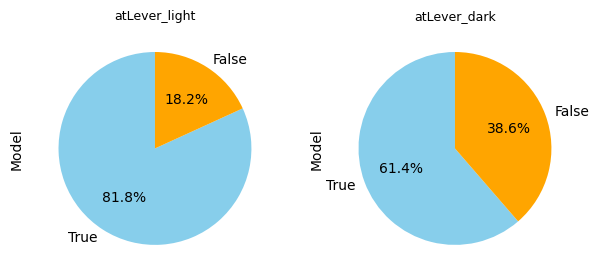

In [29]:
col = 2
row = 3
sizePerRow, sizePerCol = 2.5, 3
fig = plt.figure(figsize=(col * sizePerCol, row * sizePerRow), constrained_layout=True)
gs = gridspec.GridSpec(row, col, figure=fig, wspace=0)


lmodel = shuffled_sessions_100_LD[(shuffled_sessions_100_LD.interName== 'atLever_light') & (shuffled_sessions_100_LD.nfs>= 5)]['Model'].value_counts()
dmodel = shuffled_sessions_100_LD[(shuffled_sessions_100_LD.interName== 'atLever_dark' ) & (shuffled_sessions_100_LD.nfs>= 5)]['Model'].value_counts()

lmodel= lmodel.reindex([True, False])
dmodel= dmodel.reindex([True, False])


ax= fig.add_subplot(gs[2,0])
lmodel.plot(
    kind='pie',
    labels=['True', 'False'],
    autopct='%1.1f%%',
    colors=['skyblue', 'orange'],
    startangle=90,
)
ax.set_title('atLever_light', fontsize= 9)
ax= fig.add_subplot(gs[2,1])
dmodel.plot(
    kind='pie',
    labels=['True', 'False'],
    autopct='%1.1f%%',
    colors=['skyblue', 'orange'],
    startangle=90,
)
ax.set_title('atLever_dark', fontsize= 9)

In [35]:
shuffled_sessions_100_LD.model_performance.iloc[0].shape, shuffled_sessions_100_LD.Angle_test.iloc[0].shape

((1542,), (1542,))